In [1]:
# %pip install nltk
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install matplotlib
# %pip install tensorflow

In [41]:
from preprocess import Custom_Preprocessor

import os
import pickle
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, SpatialDropout1D

In [4]:
train_df = pd.read_excel("..\Category Data\crime_type_data.xlsx")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49317 entries, 0 to 49316
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   49317 non-null  object
 1   Type    49317 non-null  object
dtypes: object(2)
memory usage: 770.7+ KB
None


In [5]:
print(train_df.describe())

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

                                                    Title    Type
count                                               49317   49317
unique                                              48629       4
top     #Bulandshahr: Class 12 girl kidnapped, raped a...  Murder
freq                                                    4   29467
All entries unique: False
Null cells: 0


In [6]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

train_df.to_excel("..\Category Data\crime_type_data_filtered.xlsx", index=False)

All entries unique: True
Null cells: 0


In [7]:
Preprocessor = Custom_Preprocessor()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sgfri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
filtered_df = pd.DataFrame(columns=['text', 'label', 'word_count', 'label_name'])

filtered_df['label_name'] = pd.Series(pd.Categorical(train_df['Type']))
filtered_df['label'] = (pd.Categorical(filtered_df['label_name']).codes).astype(int)
label_ids = dict(enumerate(filtered_df['label_name'].cat.categories))

print("Label IDs")
print(label_ids)

filtered_df['text'], filtered_df['word_count'] = Preprocessor.preprocess_data_x(train_df['Title'], get_word_count=True)
filtered_df = filtered_df[filtered_df['word_count']>2]
print(filtered_df.head())

Label IDs
{0: 'Kidnap', 1: 'Murder', 2: 'Rape', 3: 'Theft'}
                                                text  label  word_count  \
0  delhi heinous crimes per cent cases reported t...      0           9   
1  missing teenager found dead family attacks pol...      0           9   
2  indian american man fails bring kid back us co...      0          12   
3  kidnapping case rubaiya sayeed mehbooba mufti ...      0          12   
4  bihar veterinary called check animal kidnapped...      0           8   

  label_name  
0     Kidnap  
1     Kidnap  
2     Kidnap  
3     Kidnap  
4     Kidnap  


Murder    29411
Rape      10353
Theft      4524
Kidnap     4341
Name: Type, dtype: int64


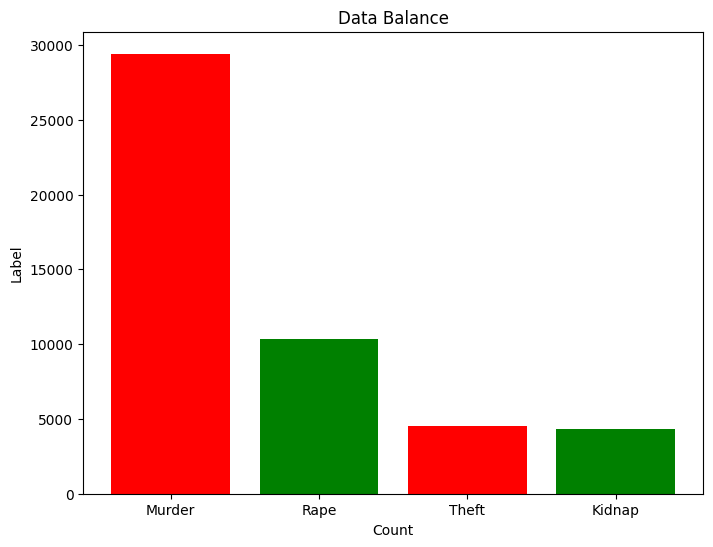

Average Word count: 14.800123418697932
        Max Word Count: 47
        Min Word Count: 3


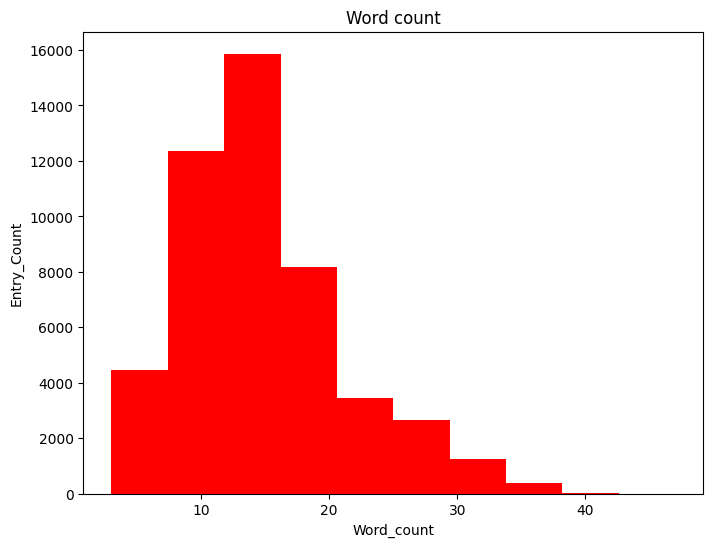

In [9]:
label_counts = train_df['Type'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

print(f'Average Word count: {np.average(filtered_df["word_count"])}\n\
        Max Word Count: {max(filtered_df["word_count"])}\n\
        Min Word Count: {min(filtered_df["word_count"])}')

plt.figure(figsize=(8, 6))
plt.hist(filtered_df['word_count'],color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [29]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = max(filtered_df["word_count"])
EMBEDDING_DIM = 5
OOV_TOK= '<OOV>'

TEST_SIZE = 0.4
VALIDATION_SIZE = 0.1
LR = 0.001
DECAY = 1e-6
NUM_EPOCH = 25
MIN_CONFIDENCE = 0.8

In [30]:
Preprocessor.set_max_seq_length(MAX_SEQUENCE_LENGTH)

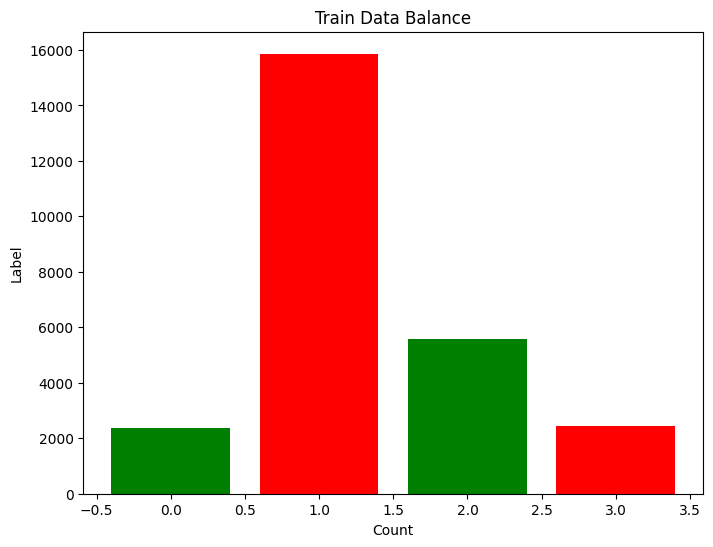

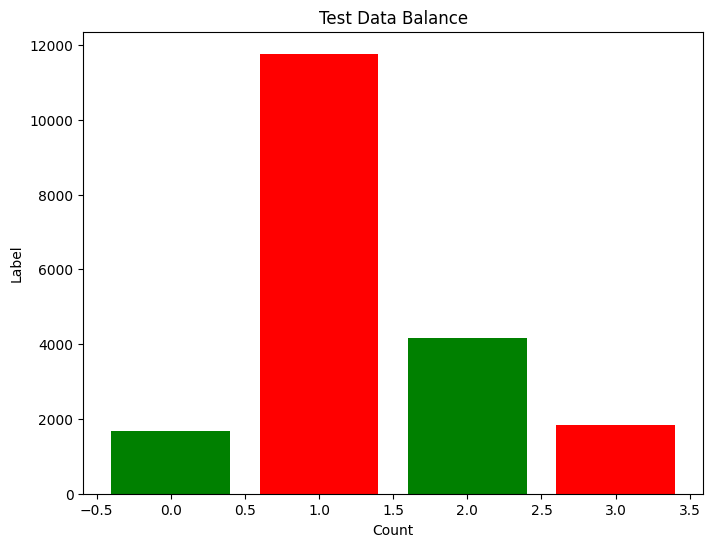

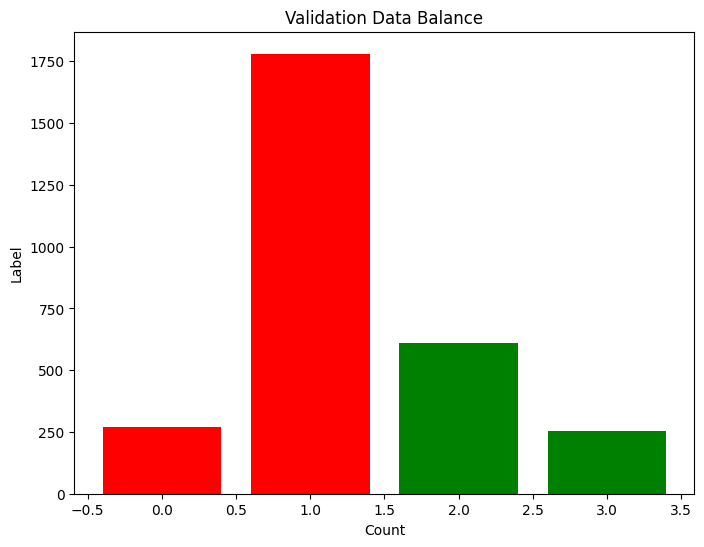

In [31]:
x_train_val,x_test,y_train_val,y_test = train_test_split(filtered_df['text'], filtered_df['label'], test_size=TEST_SIZE,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(x_train_val, y_train_val, test_size=VALIDATION_SIZE,shuffle=True)

train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()
val_label_counts = y_val.value_counts()

plt.figure(figsize=(8, 6))
plt.bar(train_label_counts.index, train_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Train Data Balance')
plt.show()
plt.figure(figsize=(8, 6))
plt.bar(test_label_counts.index, test_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Test Data Balance')
plt.show()
plt.figure(figsize=(8, 6))
plt.bar(val_label_counts.index, val_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Validation Data Balance')
plt.show()

In [32]:
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, oov_token=OOV_TOK)
tokenizer.fit_on_texts(filtered_df['text'])
print(f'Total Entries/Tweets: {len(filtered_df)}\n\
        Total Tokens: {len(tokenizer.word_index)}\n\
        Token Limit: {MAX_NB_WORDS}')

x_train_padded = Preprocessor.tokenise(tokenizer, x_train)
x_test_padded = Preprocessor.tokenise(tokenizer, x_test)
x_val_padded = Preprocessor.tokenise(tokenizer, x_val)

Total Entries/Tweets: 48615
        Total Tokens: 72306
        Token Limit: 75000


In [33]:
model = Sequential()

model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(EMBEDDING_DIM)))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 5)           375000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, None, 5)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 10)               440       
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 375,484
Trainable params: 375,484
Non-trainable params: 0
_________________________________________________________________


In [34]:
optimizer = Adam(learning_rate=LR, weight_decay=DECAY)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

earlystopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001, restore_best_weights=True)

history = model.fit(
    x_train_padded, y_train,
    epochs=NUM_EPOCH,
    # validation_split=0.1,
    validation_data=(x_val_padded, y_val),
    callbacks=[earlystopping],
    verbose=2)

Epoch 1/25
821/821 - 13s - loss: 0.7794 - accuracy: 0.7088 - val_loss: 0.5986 - val_accuracy: 0.7604 - 13s/epoch - 16ms/step
Epoch 2/25
821/821 - 10s - loss: 0.4656 - accuracy: 0.8293 - val_loss: 0.4613 - val_accuracy: 0.8423 - 10s/epoch - 12ms/step
Epoch 3/25
821/821 - 10s - loss: 0.3450 - accuracy: 0.8846 - val_loss: 0.4121 - val_accuracy: 0.8574 - 10s/epoch - 12ms/step
Epoch 4/25
821/821 - 10s - loss: 0.2559 - accuracy: 0.9163 - val_loss: 0.3997 - val_accuracy: 0.8615 - 10s/epoch - 12ms/step
Epoch 5/25
821/821 - 10s - loss: 0.1972 - accuracy: 0.9368 - val_loss: 0.4104 - val_accuracy: 0.8629 - 10s/epoch - 13ms/step
Epoch 6/25
821/821 - 10s - loss: 0.1611 - accuracy: 0.9480 - val_loss: 0.4276 - val_accuracy: 0.8632 - 10s/epoch - 13ms/step
Epoch 7/25
821/821 - 11s - loss: 0.1381 - accuracy: 0.9553 - val_loss: 0.4671 - val_accuracy: 0.8581 - 11s/epoch - 13ms/step
Epoch 8/25
821/821 - 13s - loss: 0.1228 - accuracy: 0.9601 - val_loss: 0.4779 - val_accuracy: 0.8567 - 13s/epoch - 16ms/step


In [38]:
accr = model.evaluate(x_test_padded,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

608/608 [==============================] - 1s 2ms/step - loss: 0.4104 - accuracy: 0.8674
Test set
  Loss: 0.410
  Accuracy: 0.867


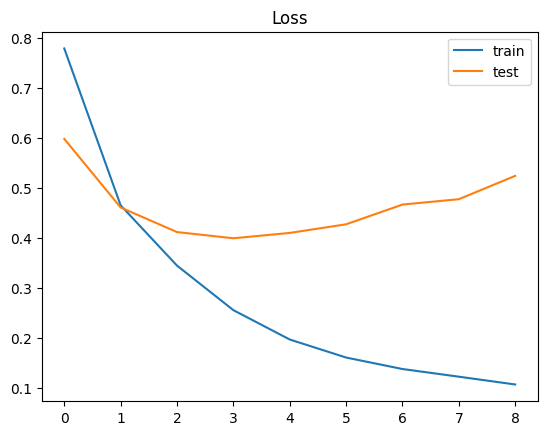

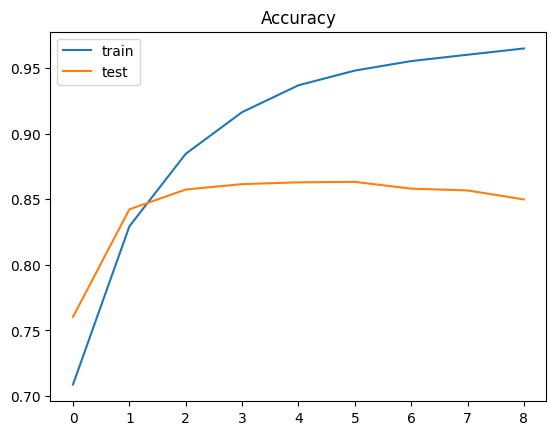

In [39]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [37]:
new_complaints = [
    "Government makes GST compulsory", 
    "Aviral commited theft by stealing my pen",
    "Kartik stabbed his roommate out of spite",
    "Aryan abducted by aliens"
    ]

pre_complaint = Preprocessor.preprocess_data_x(new_complaints)
# print(pre_complaint)
# print(tokenizer.texts_to_sequences(pre_complaint))
padded = Preprocessor.tokenise(tokenizer, pre_complaint)
pred_list = model.predict(padded)

print(pred_list)
for i in range(len(pred_list)):
    print(new_complaints[i])
    max_con = np.max(pred_list[i])
    if max_con >= MIN_CONFIDENCE:
        print(f'{label_ids[np.argmax(pred_list[i])]}: {max_con*100:.2f}')
    else:
        print('None')

1/1 [==============================] - 1s 1s/step
[[2.2623417e-01 3.5199603e-01 8.5280417e-03 4.1324177e-01]
 [7.4806456e-03 4.0858481e-03 2.8496544e-04 9.8814851e-01]
 [8.9804502e-03 9.7558039e-01 8.9910682e-03 6.4480328e-03]
 [8.9937007e-01 3.4575418e-03 2.4603684e-02 7.2568685e-02]]
Government makes GST compulsory
None
Aviral commited theft by stealing my pen
Theft: 98.81
Kartik stabbed his roommate out of spite
Murder: 97.56
Aryan abducted by aliens
Kidnap: 89.94


In [46]:
dir_path = f"./Weights/{accr[0]*100:.2f}_{accr[1]*100:.2f}"

if not os.path.isdir(dir_path):
    os.makedirs(dir_path)

with open(dir_path+'/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save(dir_path+'/model')
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

INFO:tensorflow:Assets written to: ./Weights/41.04_86.74/model\assets


INFO:tensorflow:Assets written to: ./Weights/41.04_86.74/model\assets
